# Tutorial - Green Urban Scenarious
A demo of a minimal flow of GUS process.

For more advanced use cases, please see upcoming article. For more structured experiment and scenario analyis plese see model sepcification and code documentation within docs/ folder. 

In [ ]:
# Install the GUS framework.

import sys
!{sys.executable} -m pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple gus==0.1.7

In [29]:
#%load_ext autoreload
%reload_ext autoreload
%autoreload 3
%matplotlib inline
from pkg_resources import resource_filename
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os, sys, json
import pkgutil
import pprint
pp = pprint.PrettyPrinter(indent=1)
sns.set_theme()

## 0. Importing GUS modules

In [30]:
from src.gus.models import Urban
from src.gus.utilities import get_raster_data

## 1. Initilisation

### 1.1 Importing data on site, tree populations, experiment parameters

In [31]:
import logging
logfile = os.path.join("../src", "gus/outputs/gus.log")
logging.basicConfig(filename=logfile, format='%(asctime)s %(levelname)s %(message)s', level=logging.INFO)

# File that holds site/city other geolocated data and parameters
fname_config_site = resource_filename("src", "gus/inputs/site.json")

# File that include tree species specific parameters
fname_config_allometrics = resource_filename("src", "gus/inputs/allometrics.json")

# File that include individual tree data including their location on a 2D raster of the actual location
fname_data_trees = resource_filename("src", "gus/inputs/trees.csv")

# File that holds experiment parameters
fname_scenario_params = resource_filename("src", "gus/inputs/scenario.json")

In [32]:
f = open(fname_config_allometrics)
config_allometrics = json.loads(f.read())
#pp.pprint(config_allometrics)

In [33]:
f = open(fname_config_site)
config_site = json.loads(f.read())
pp.pprint(config_site)

{'area_impervious_in_m2': 500,
 'area_pervious_in_m2': 500,
 'area_total_in_m2': 1000,
 'area_tree_density_per_hectare': 400,
 'project_site_type': 'park',
 'weather': {'growth_season_mean': 200, 'growth_season_var': 7}}


In [34]:
df_pop = pd.read_csv(fname_data_trees)
df_pop.tail()

,id,species,dbh,height,condition,xpos,ypos
95,96,conifer,13.871098,3.303454,good,17,4
96,97,conifer,12.561324,3.165903,good,17,5
97,98,conifer,13.651542,3.436859,good,17,6
98,99,conifer,12.610441,3.195499,good,17,3
99,100,conifer,12.491068,3.467151,excellent,17,7


In [35]:
f = open(fname_scenario_params)
scenario_params = json.loads(f.read())
pp.pprint(scenario_params)

{'is_crownsunexposure_fixed': 1,
 'maintenance_scope': 2,
 'time_horizon_years': 50}


### 1.2 Creating a digital twin of the site

In [36]:
site = Urban(df_pop,
            fname_config_allometrics,
            fname_config_site,
            scenario_params)

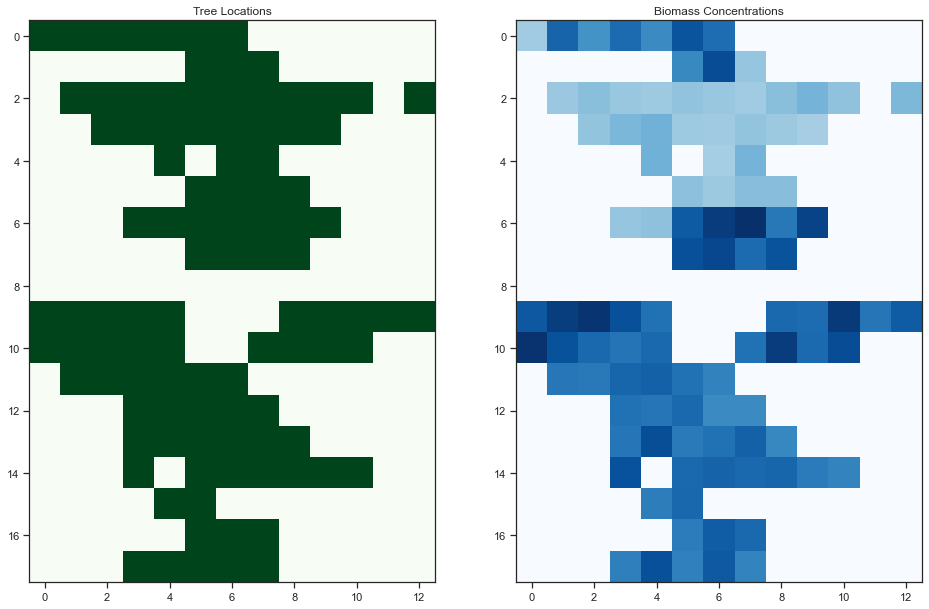

In [37]:
initial_locations = get_raster_data(site, counts=True)
initial_biomass = get_raster_data(site, var='biomass')

sns.set_style("ticks")
fig = plt.figure(figsize=(16,12))
plt.subplot(121)
plt.imshow(initial_locations, cmap='Greens')
plt.title("Tree Locations")
plt.subplot(122)
plt.title("Biomass Concentrations")
plt.imshow(initial_biomass, cmap='Blues')
#plt.colorbar(label = 'Biomass - Kg')
plt.show()

## 2. Running the scenario

In [38]:
for i in range(scenario_params['time_horizon_years']):
    site.step()

## 3. Analysis

### 3.1 Individual tree level inspections 

In [39]:
# Tree level individual variables
fname_output_trees = os.path.join("../src", "gus/outputs/trees_yearly.json")
df_out_tree = site.datacollector.get_agent_vars_dataframe()
df_out_tree.to_csv(fname_output_trees, index=True)
df_out_tree.tail()

species        dbh    height    crownH    crownW  \
Step AgentID                                                     
50   168       decidu  11.318872  9.308317  4.837098  4.188620   
     169       decidu  12.240165  9.712507  5.082395  4.401332   
     170      conifer  10.196881  6.444752  4.071138  2.555131   
     171      conifer  10.228828  6.462722  4.079543  2.561090   
     172       decidu   9.197756  8.316054  4.257468  3.688400   

              canopy_overlap       cle  condition   dieback    biomass  \
Step AgentID                                                             
50   168            0.307545  0.836917  excellent  0.005313  55.669067   
     169            0.163847  0.917741  excellent  0.002980  66.387401   
     170            0.069372  0.959620  excellent  0.000094  36.809711   
     171            0.200136  0.883662  excellent  0.005502  37.092435   
     172            0.000000  0.560000  excellent  0.008239  34.899665   

                   seq     carbon  deroot  detrunk   mulched  burnt  \
Step AgentID                                                          
50   168      5.937846  27.834534     0.0      0.0  0.007395    0.0   
     169      7.189507  33.193700     0.0      0.0  0.004946    0.0   
     170      2.961742  18.404856     0.0      0.0  0.000087    0.0   
     171      2.737088  18.546217     0.0      0.0  0.005102    0.0   
     172      0.000000  17.449832     0.0      0.0  0.000000    0.0   

             coordinates  
Step AgentID              
50   168          (5, 8)  
     169         (2, 10)  
     170         (14, 5)  
     171          (1, 5)  
     172          (6, 3)

In [40]:
Specific_Tree = df_out_tree.xs(42, level="AgentID")
Specific_Tree.tail()

,species,dbh,height,crownH,crownW,canopy_overlap,cle,condition,dieback,biomass,seq,carbon,deroot,detrunk,mulched,burnt,coordinates
Step,,,,,,,,,,,,,,,,,
46,decidu,50.590807,20.994087,11.821003,10.808163,0.876666,0.702496,excellent,0.006,1617.562327,11.987415,808.781163,0.0,0.0,0.242634,0.0,"(6, 8)"
47,decidu,50.917538,21.067629,11.849278,10.842209,0.877813,0.702535,excellent,0.007,1641.164660,11.801167,820.582330,0.0,0.0,0.287204,0.0,"(6, 8)"
48,decidu,51.245809,21.141301,11.877191,10.876065,0.884056,0.699998,excellent,0.006,1665.069735,11.952537,832.534867,0.0,0.0,0.249760,0.0,"(6, 8)"
49,decidu,51.561223,21.211885,11.903542,10.908266,0.948544,0.683783,excellent,0.005,1688.219644,11.574955,844.109822,0.0,0.0,0.211027,0.0,"(6, 8)"
50,decidu,51.835738,21.273156,11.926103,10.936028,0.952445,0.682509,excellent,0.006,1708.512311,10.146334,854.256156,0.0,0.0,0.256277,0.0,"(6, 8)"


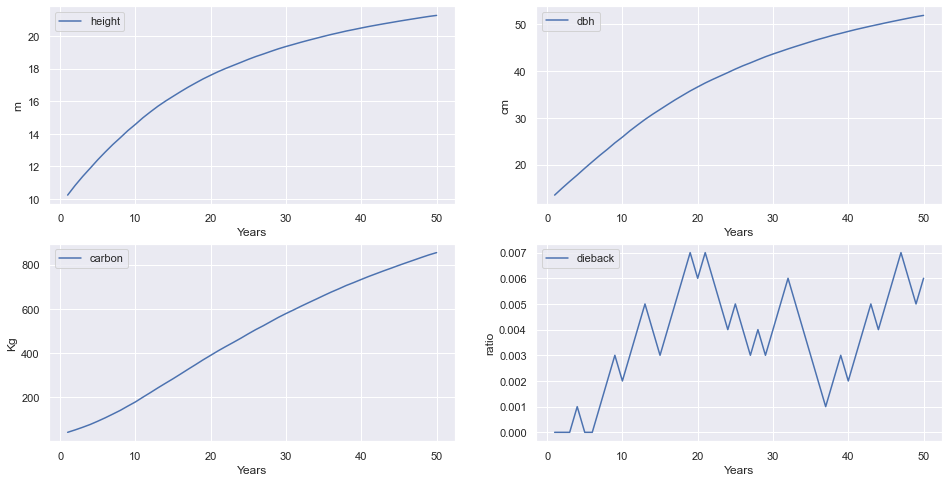

In [41]:
sns.set_theme()
fig = plt.figure(figsize=(16,8))
plt.subplot(221)
Specific_Tree.height.plot()
plt.xlabel('Years')
plt.ylabel('m')
plt.legend()
plt.subplot(222)
Specific_Tree.dbh.plot()
plt.xlabel('Years')
plt.ylabel('cm')
plt.legend()
plt.subplot(223)
Specific_Tree.carbon.plot()
plt.xlabel('Years')
plt.ylabel('Kg')
plt.legend()
plt.subplot(224)
Specific_Tree.dieback.plot()
plt.xlabel('Years')
plt.ylabel('ratio')
plt.legend()
plt.show()

### 3.2 Site level inspections

In [42]:
# Site level aggregate variables
df_out_site = site.datacollector.get_model_vars_dataframe()
df_out_site.tail()

,Storage,Seq,Released,Alive,Dead,Critical,Dying,Poor,Replaced,Seq_std
45,70821.300025,1633.519468,219.769665,100,0,0,0,0,66,9.676580
46,72445.808351,1624.508326,468.766944,97,3,0,0,0,66,9.954620
47,74168.842866,1669.176145,694.754197,98,2,0,0,0,69,10.436513
48,75883.867061,1683.771951,621.492638,99,1,0,0,0,71,10.494115
49,77408.337388,1507.020494,665.438017,99,1,0,0,0,72,9.427749


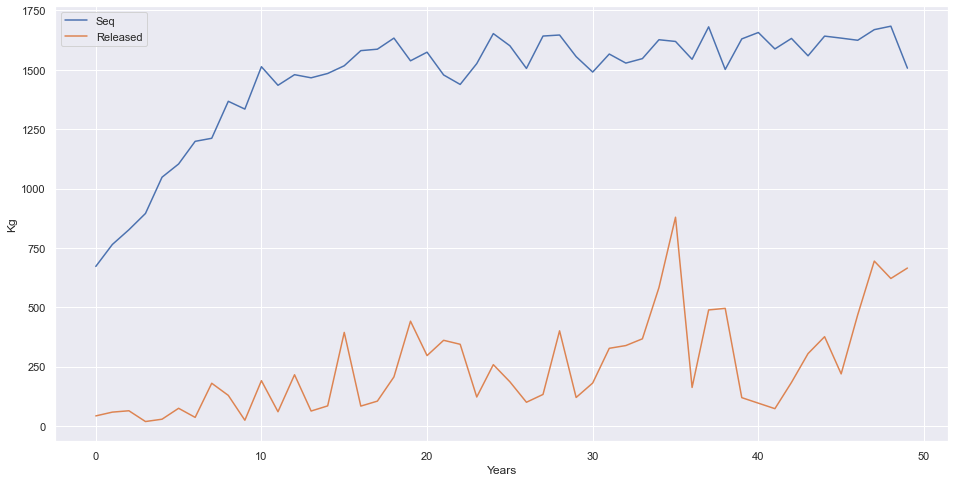

In [43]:
fig = plt.figure(figsize=(16,8))
df_out_site.Seq.plot()
df_out_site.Released.plot()
plt.xlabel('Years')
plt.ylabel('Kg')
plt.legend()
plt.show()

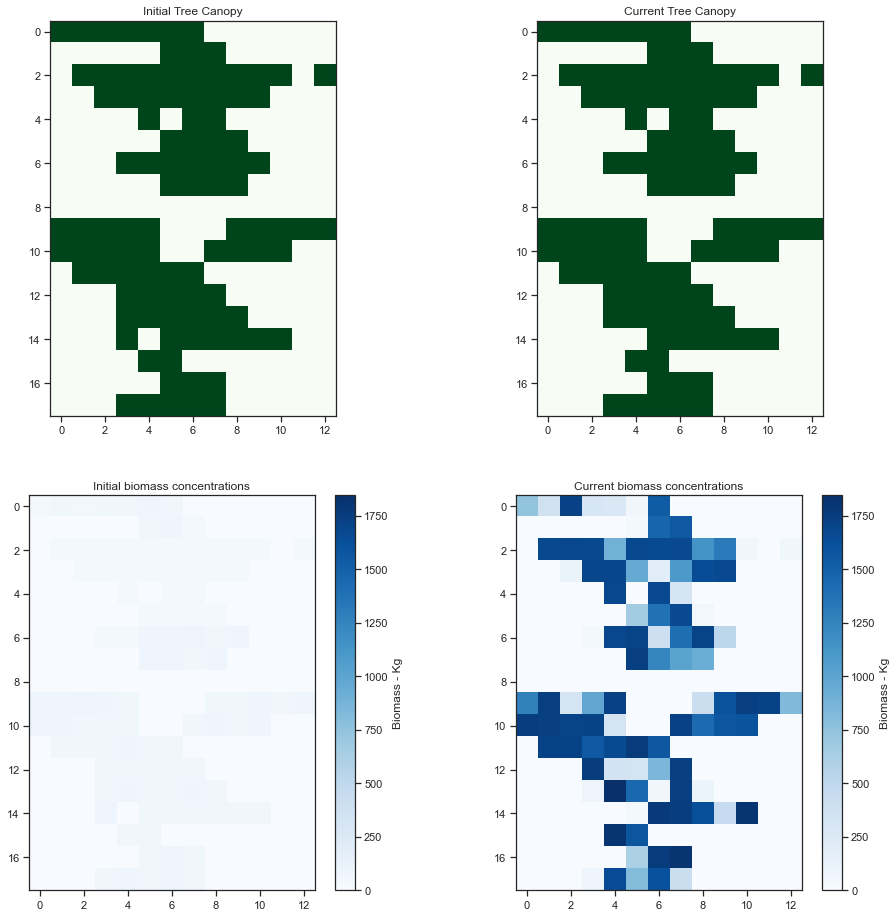

In [44]:
locations = get_raster_data(site, counts=True)
biomass = get_raster_data(site, var='biomass')

sns.set_style("ticks")
fig = plt.figure(figsize=(16,16))
plt.subplot(221)
plt.imshow(initial_locations, cmap='Greens')
plt.title("Initial Tree Canopy")

plt.subplot(222)
plt.imshow(locations, cmap='Greens')
plt.title("Current Tree Canopy")

plt.subplot(223)
plt.title("Initial biomass concentrations")
plt.imshow(initial_biomass, cmap='Blues', vmin=0, vmax=biomass.max())
plt.colorbar(label = 'Biomass - Kg')

plt.subplot(224)
plt.title("Current biomass concentrations")
plt.imshow(biomass, cmap='Blues')
plt.colorbar(label = 'Biomass - Kg')
plt.show()